In [8]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm # progress bar
from model import UNet
from torch.optim import Adam

## Creation of the Dataset class

In [4]:
class StentDataset(Dataset):
    def __init__(self):
        self.input_path = "./data/dataset/train/x"
        self.target_path = "./data/dataset/train/y"
        self.input_files = os.listdir(self.input_path)
        self.target_files = os.listdir(self.target_path)
        self.input_files.sort()
        self.target_files.sort()

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        # files corresponding to the index
        input_file = self.input_files[idx]
        target_file = self.target_files[idx]
        # load the image
        input_img = Image.open(os.path.join(self.input_path, input_file))
        target_img = Image.open(os.path.join(self.target_path, target_file))
        # convert to numpy array
        input_img = torch.tensor(np.array(input_img), dtype=torch.double)
        target_img = torch.tensor(np.array(target_img), dtype=torch.double)
        # crop the image
        delta = 94 # we loose 94 pixels on each side during convolution
        target_image = target_img[delta:-delta, delta:-delta]
        # normalize the image
        input_img = input_img / 2 ** 16
        target_image = target_image / 2 ** 16
        # return the image
        return input_img, target_image

In [6]:
model = UNet(in_channels=1, out_channels=1)
model.double()
dataset = StentDataset()
training_loader = DataLoader(dataset, batch_size=1, shuffle=True)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

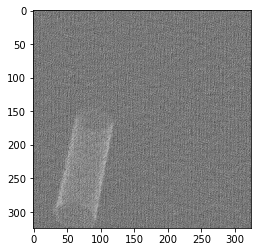

In [7]:
# initial prediction image
plt.imshow(dataset[26][0], cmap="gray")
prediction = model(dataset[26][0].reshape(1, 512, 512))
plt.imshow(prediction.detach().numpy()[0], cmap="gray")

In [9]:
# parameters
epochs = 1
batch_size = 1

# training
losses = []
for epoch in range(epochs):
    for i, data in enumerate(tqdm(training_loader)):
        # get the inputs
        inputs, targets = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        # print statistics
        losses.append(loss.item())
        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
              .format(epoch + 1, epochs, i + 1, len(training_loader), loss.item()))

  0%|          | 1/1600 [00:10<4:32:42, 10.23s/it]

Epoch [1/1], Step [1/1600], Loss: 1.1879


  0%|          | 2/1600 [00:18<4:04:49,  9.19s/it]

Epoch [1/1], Step [2/1600], Loss: 1.0605


  0%|          | 3/1600 [00:28<4:07:05,  9.28s/it]

Epoch [1/1], Step [3/1600], Loss: 0.7374


  0%|          | 4/1600 [00:36<4:02:07,  9.10s/it]

Epoch [1/1], Step [4/1600], Loss: 0.3311


  0%|          | 4/1600 [00:46<5:06:14, 11.51s/it]


KeyboardInterrupt: 

In [ ]:
# save the model
